In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [83]:
columns = [
    "lat",
    "lon",
    "id",
    "title",
    "start_ts",
    "report_type",
    "severity",
    "lat_long",
    "severity_score",
    "city",
    "anomalous"
]

In [84]:
df = pd.read_csv("data/flagged_reports.csv", header=None)
df = df.drop(0, axis=1)
df.columns = columns
df = df.sort_values("start_ts")
print df.head()

         lat        lon                      id  \
69  41.85003  -87.65005  4EMFcGPA5hGB_BzRy13KCQ   
70  11.84692   13.15712  XKS_N2TA5hGCYRvRy13KCQ   
71  34.39256 -100.89764  HMhll2vA5hGLHhzRy13KCQ   
72  28.03947  -81.94980  oGHIvGvA5hGzBBzRy13KCQ   
75  33.84918 -118.38841  _o_p3GvA5hGlnqICZNc2RA   

                                                title             start_ts  \
69  Snow, Frigid Temperatures Hit Much of Northern...  2016-12-12 12:06:39   
70  Girls 'aged 7 or 8' stage suicide attack in Ni...  2016-12-12 12:12:14   
71  Turkish citizens in Berlin protest PKK terror ...  2016-12-12 13:05:01   
72  Drane Field Road Closed In Lakeland Due Traffi...  2016-12-12 13:06:04   
75  Police Say Suspect Wounded In Shooting In San ...  2016-12-12 13:06:58   

         report_type  severity                                   lat_long  \
69             Other  moderate  (41.850029999999997, -87.650049999999993)   
70  Physical Threats      high   (11.846919999999999, 13.1571200000000

In [85]:
berlin_df = df[df["city"] == "Berlin"]
berlin_df = berlin_df.set_index("start_ts")
print berlin_df.info()
print berlin_df.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 2016-12-15 09:05:42 to 2016-12-24 19:05:57
Data columns (total 10 columns):
lat               565 non-null float64
lon               565 non-null float64
id                565 non-null object
title             565 non-null object
report_type       565 non-null object
severity          565 non-null object
lat_long          565 non-null object
severity_score    565 non-null int64
city              565 non-null object
anomalous         565 non-null float64
dtypes: float64(3), int64(1), object(6)
memory usage: 48.6+ KB
None
                           lat       lon                      id  \
start_ts                                                           
2016-12-15 09:05:42  52.524370  13.41053  ivw0qKXC5hGSewfRy13KCQ   
2016-12-19 00:00:00  52.504884  13.33537  FKem1TLG5hGUxTPRy13KCQ   
2016-12-19 00:00:00  52.504884  13.33537  Dvc79yzG5hGrfkcO+RcZ4Q   
2016-12-19 00:00:00  52.504884  13.33537  cipqGSfG5hGFwUMO+RcZ4Q   
2016-12-

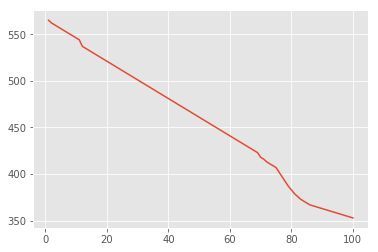

In [92]:
next_day = pd.Timedelta(days=1)

cutoffs = xrange(1, 101)
num_critical = []
for cutoff in cutoffs:
    lst = []
    for row in berlin_df.iterrows():
        report_time = pd.to_datetime(row[0])
        stop_time = min(report_time+next_day, pd.to_datetime(max(berlin_df.index)))
        future_reports = berlin_df[str(report_time):str(stop_time)]
        if len(future_reports) >= cutoff:
            lst.append(1)

    num_critical.append(sum(lst))
#     print "Number of reports deemed anomalous: ", len(berlin_df)
#     print "Number of reports deemed critical: ", sum(lst)

plt.plot(cutoffs, num_critical)

In [87]:
def plot_cutoffs_to_critical_reports(ax, city_df, cutoffs=xrange(1, 51)):
    next_day = pd.Timedelta(days=1)
    num_critical = []
    for cutoff in cutoffs:
        lst = []
        for row in city_df.iterrows():
            report_time = pd.to_datetime(row[0])
            stop_time = min(report_time+next_day, pd.to_datetime(max(berlin_df.index)))
            future_reports = city_df[str(report_time):str(stop_time)]
            if len(future_reports) >= cutoff:
                lst.append(1)

        num_critical.append(sum(lst))

    ax.plot(cutoffs, num_critical)
    ax.set_xlabel("Cutoff")
    ax.set_ylabel("Num Critical")
    ax.set_title(city_df.iloc[0,-2])
    

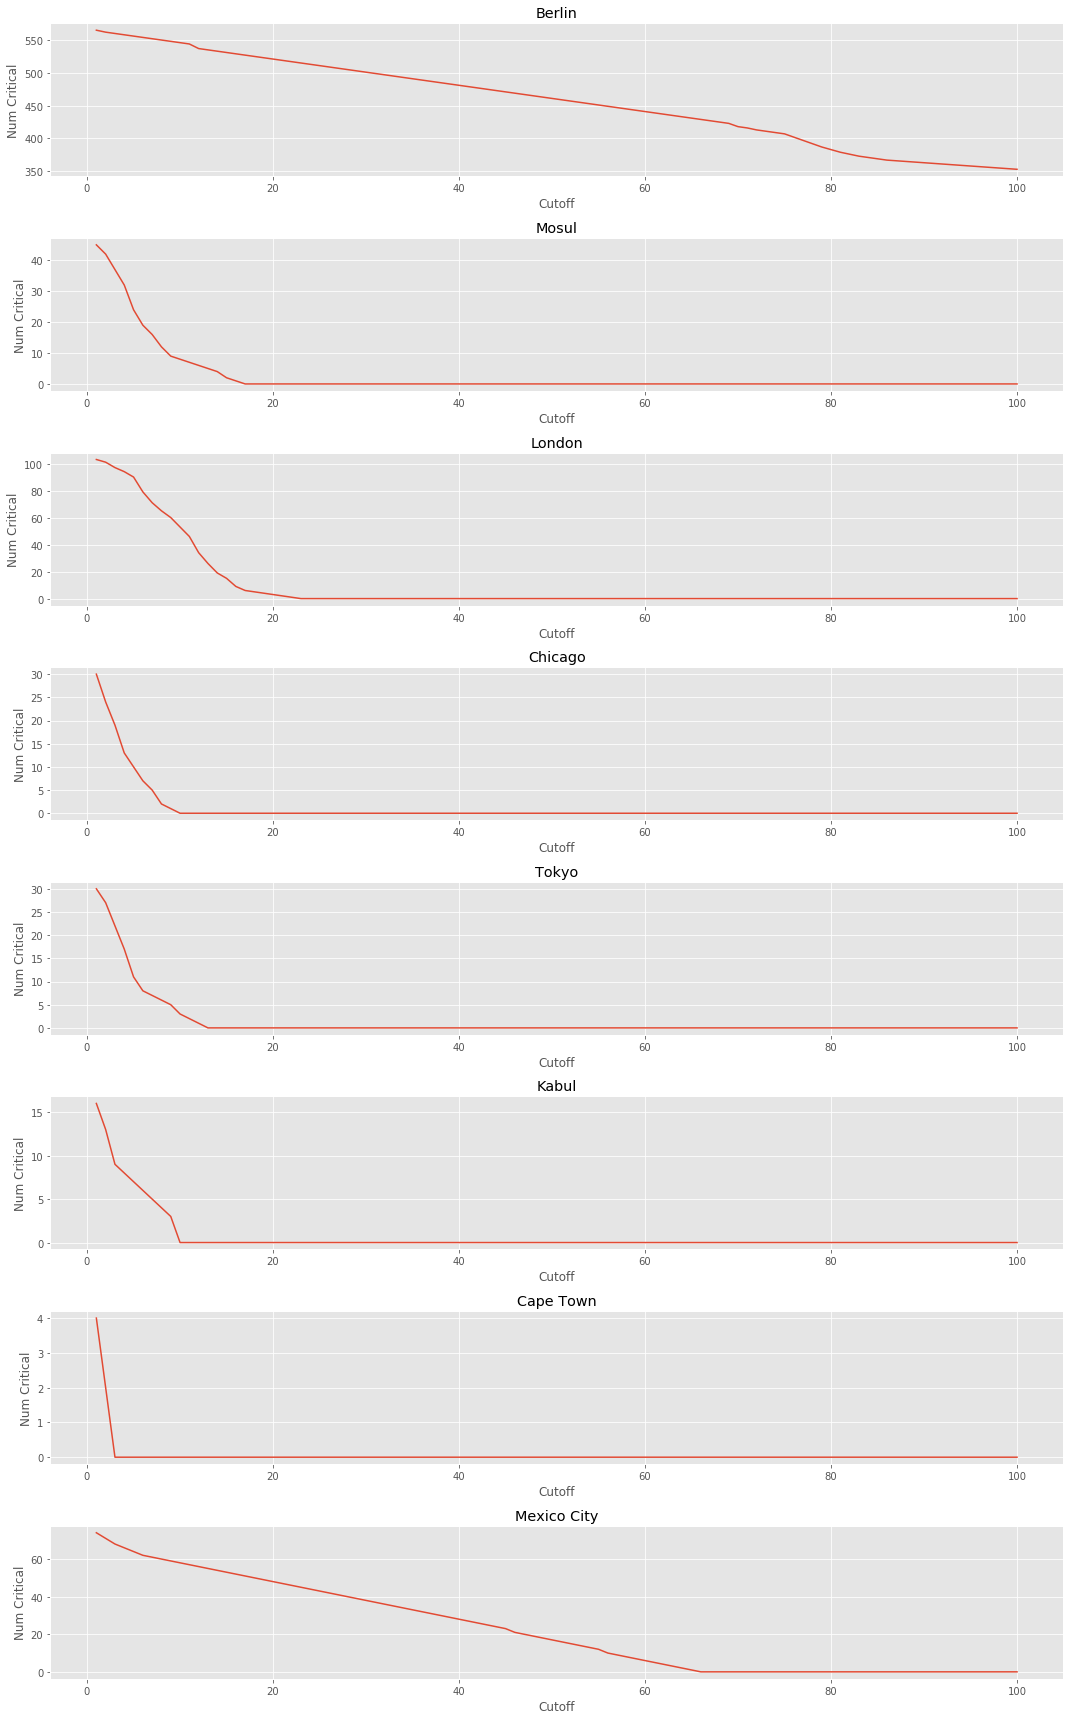

In [91]:
cities = ["Berlin", "Mosul", "London", "Chicago", "Tokyo", "Kabul", "Cape Town", "Mexico City"]
fig, axes = plt.subplots(len(cities), figsize=(15,24))

for i, ax in enumerate(axes.flatten()):
    city_df = df[df["city"] == cities[i]]
    city_df = city_df.set_index("start_ts")
    plot_cutoffs_to_critical_reports(ax, city_df, cutoffs=xrange(1, 101))

plt.tight_layout()

## Given these filter setttings:

    3 minute resample rate
    1 week mean and standard deviation window
    Quadratic severity scoring
    Mean + 1 STD as the anomaly threshold

## 30 anomalous reports over the next 24 hours seems to be a reasonable cutoff for determining whether a report is critical or simply anomalous.

# This cutoff must be tuned based off the specific settings of the filter layer. For example, increasing the threshold to mean + 2 * STD would require reducing the cutoff to ~10 anomalous reports over the next 24 hours. Precise tuning of the complete model will require cross-validation and grid search of BOTH layers simultaneously